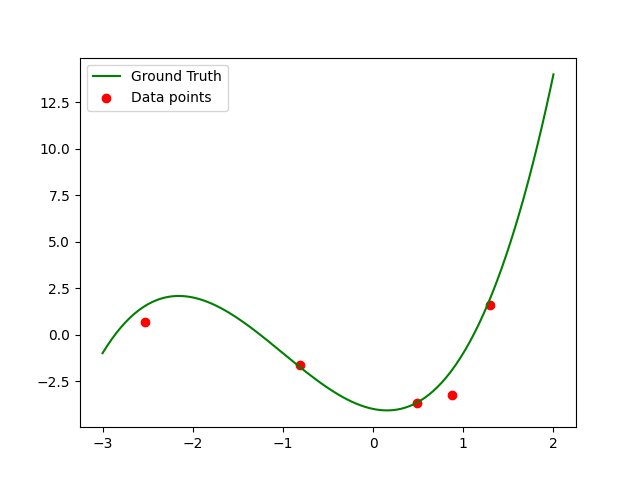

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets

x_min, x_max = -3, 2
num_data = 5
data_noise = 1.0
num_plot = 200

def fun(x):
    return x**3 + 3 * x**2 - x - 4

gen = np.random.default_rng(seed=42)
x_data = gen.uniform(size=(num_data,), low=x_min, high=x_max)
y_data = fun(x_data) + data_noise * gen.standard_normal(x_data.shape) 

x_plot = np.linspace(x_min, x_max, num=num_plot)
y_plot = fun(x_plot)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, y_plot, color="green", label="Ground Truth")
ax.scatter(x_data, y_data, color="red", label="Data points")
ax.legend(loc="upper left")
None

In [2]:
def create_rbf_feature_fun(n: int, dtype=np.float64):
    # centers within 3 sigma of data range
    center_min = x_min - 3
    center_max = x_max + 3
    centers = np.linspace(center_min, center_max, n, dtype=dtype)
    def rbf_fun(x):
        # let's restrict to 1d inputs
        assert x.ndim == 1
        # shape [x, features]
        return np.exp(- (np.expand_dims(x,1) - np.expand_dims(centers,0))**2)

    # each feature needs to be weighted by the d mu of the centers
    d_mu = (center_max - center_min) / n
    # and another normalization factor
    weighting = np.ones_like(centers, dtype=dtype) * d_mu * (2/np.pi)**0.25
    return rbf_fun, weighting

def create_feature_kernel_function(feature_fun, weighting):
    def kernel(x, y):
        assert x.ndim == 1
        assert y.ndim == 1
        # compute features
        x_feats = feature_fun(x)
        y_feats = feature_fun(y)
        # broadcasting for every x vs. every y comparison, shape [x, y, centers]
        feat_cmp = (x_feats[:, None, :] * y_feats[None, :, :])
        # manual weighted dot product
        return (feat_cmp * weighting).sum(axis=-1)
    return kernel

def gaussian_kernel_function(x, y):
    assert x.ndim == 1
    assert y.ndim == 1
    # shape [x, y]
    return np.exp(- (np.expand_dims(x,1) - np.expand_dims(y,0))**2 / 2 )


# Each RBF feature $\phi_i(x)$

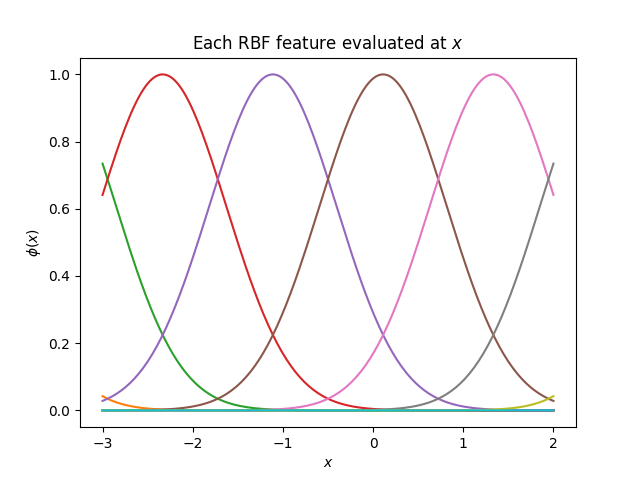

In [3]:
rbf, _ = create_rbf_feature_fun(10)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, rbf(x_plot))
ax.set_title("Each RBF feature evaluated at $x$")
ax.set_xlabel("$x$")
ax.set_ylabel("$\phi(x)$")
None

# Gaussian Kernel function $k(x, x_i)$ against data

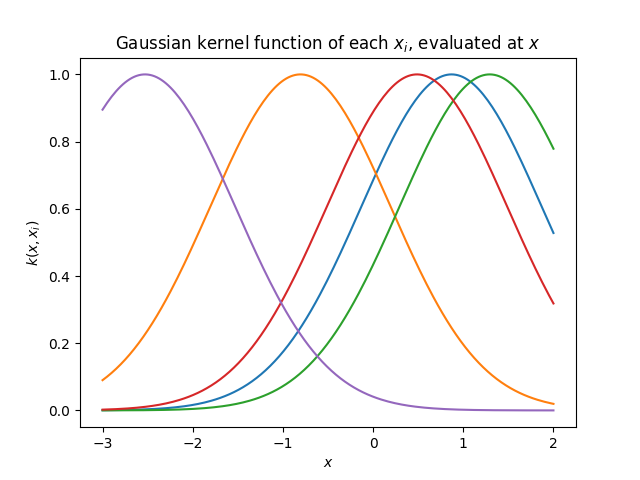

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, gaussian_kernel_function(x_plot, x_data))
ax.set_title("Gaussian kernel function of each $x_i$, evaluated at $x$")
ax.set_xlabel("$x$")
ax.set_ylabel("$k(x, x_i)$")
None

# RBF dot-product Kernel function $k_\phi(x, x_i)$ against data

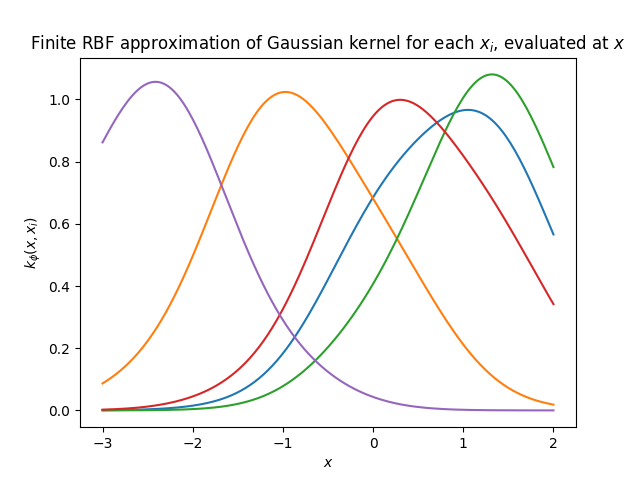

In [5]:
rbf, weighting = create_rbf_feature_fun(10)
rbf_kernel = create_feature_kernel_function(rbf, weighting)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, rbf_kernel(x_plot, x_data))
ax.set_title("Finite RBF approximation of Gaussian kernel for each $x_i$, evaluated at $x$")
ax.set_xlabel("$x$")
ax.set_ylabel("$k_{\phi}(x, x_i)$")
None

# Comparison of Gaussian kernel vs RBF kernel at different feature dimensionalities

interactive(children=(IntSlider(value=10, description='N', max=50, min=1), Output()), _dom_classes=('widget-in…

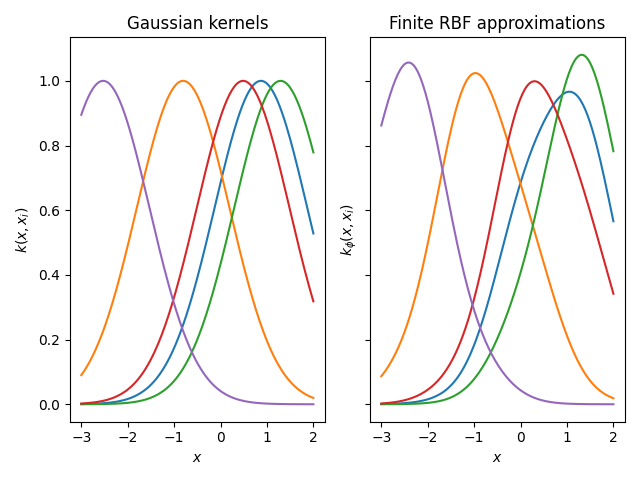

In [6]:
fig = plt.figure()
ax1, ax2 = fig.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
gaussian_lines = ax1.plot(x_plot, gaussian_kernel_function(x_plot, x_data))
rbf_lines = ax2.plot(x_plot, rbf_kernel(x_plot, x_data))

ax1.set_title("Gaussian kernels")
ax1.set_xlabel("$x$")
ax1.set_ylabel("$k(x, x_i)$")

ax2.set_title("Finite RBF approximations")
ax2.set_xlabel("$x$")
ax2.set_ylabel("$k_{\phi}(x, x_i)$")

fig.tight_layout()

def update(N):
    # create rbf features with N centers
    rbf_kernel_N, weighting_N = create_rbf_feature_fun(int(N))
    # and kernel of it
    rbf_kernel_N = create_feature_kernel_function(rbf_kernel_N, weighting_N)
    data_kernel = rbf_kernel_N(x_plot, x_data)
    for i, line in enumerate(rbf_lines):
        line.set_ydata(data_kernel[:, i])
    fig.canvas.draw_idle()
    
_ = interact(update, N = ipywidgets.IntSlider(min=1, max=50, step=1, value=10))


# Kernel Trick

Let's compare runtime and numerical accuracy of both matrix inversions as we increase the feature dimensionality.

We'll first create a few more datapoints and use 15 RBFs.

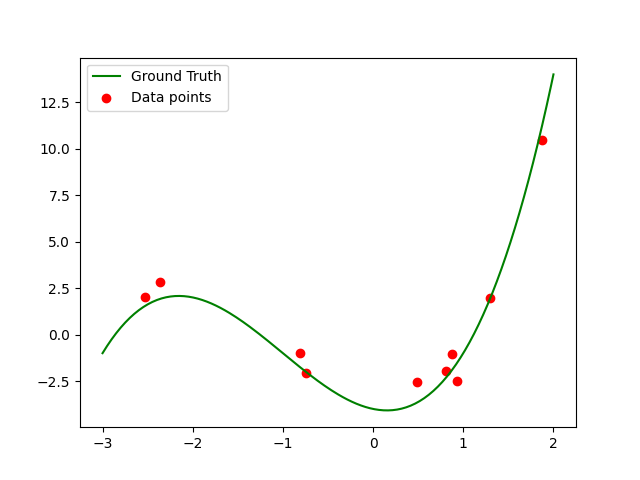

In [7]:
x_min, x_max = -3, 2
num_data = 10
data_noise = 1.0
num_plot = 200

def fun(x):
    return x**3 + 3 * x**2 - x - 4

gen = np.random.default_rng(seed=42)
x_data = gen.uniform(size=(num_data,), low=x_min, high=x_max)
y_data = fun(x_data) + data_noise * gen.standard_normal(x_data.shape) 

x_plot = np.linspace(x_min, x_max, num=num_plot)
y_plot = fun(x_plot)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, y_plot, color="green", label="Ground Truth")
ax.scatter(x_data, y_data, color="red", label="Data points")
ax.legend(loc="upper left")
None

As a reminder:

Ridge regression approach: $w = (\Phi^\top \Phi + \lambda I)^{-1} \Phi^\top y, \qquad f(x) = \phi(x)^\top w$

Kernelized approach: $w = \Phi^\top (\Phi \Phi^\top + \lambda I)^{-1} y = \Phi^\top \alpha, \qquad f(x) = \phi(x)^\top \Phi^\top \alpha = k(x)^\top \alpha$

In [8]:
def ridge(rbf, Phi, y_data, reg_lambda):
    # Phi.shape [N, d]
    # w = A^{-1} b -> A w = b
    A = Phi.mT @ Phi + reg_lambda * np.eye(N=Phi.shape[1], dtype=Phi.dtype)
    b = Phi.mT @ y_data
    w = np.linalg.solve(A, b) # solve d x d system
    def f(x_plot):
        assert x_plot.ndim == 1
        # rbf shape [plot, d], w shape [d]
        return (rbf(x_plot) * w[None, :]).sum(axis=-1)
    return f

def kernelized(rbf, Phi, y_data, reg_lambda):
    # Phi.shape [N, d]
    # alpha = A^{-1} b -> A w = b
    A = Phi @ Phi.mT + reg_lambda * np.eye(N=Phi.shape[0], dtype=Phi.dtype)
    b = y_data
    alpha = np.linalg.solve(A, b) # solve N x N system
    def f(x_plot):
        assert x_plot.ndim == 1
        # rbf shape [plot, d], Phi shape [N, d]
        k = (rbf(x_plot)[:, None, :] * Phi[None, :, :]).sum(axis=-1)
        # k shape [plot, N], alpha shape [N]
        return (k * alpha[None, :]).sum(axis=-1)
    return f

Both methods lead to identical $f(x)$

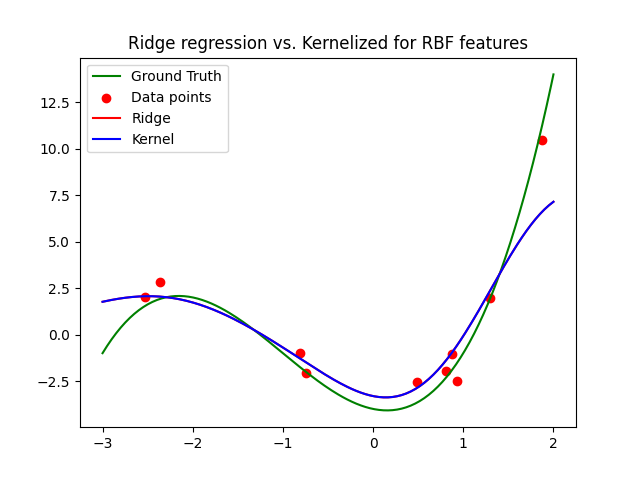

In [9]:
reg_lambda = 0.5

num_rbf = 15

rbf, _ = create_rbf_feature_fun(num_rbf)
Phi = rbf(x_data)

f_r = ridge(rbf, Phi, y_data, reg_lambda)
f_k = kernelized(rbf, Phi, y_data, reg_lambda)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, y_plot, color="green", label="Ground Truth")
ax.scatter(x_data, y_data, color="red", label="Data points")
ax.plot(x_plot, f_r(x_plot), color="red", label="Ridge")
ax.plot(x_plot, f_k(x_plot), color="blue", label="Kernel")
ax.legend(loc="upper left")
ax.set_title("Ridge regression vs. Kernelized for RBF features")
None

# Comparison with Bayesian Linear Regression

Posterior (weight) distribution is a Gaussian with mean
$$\bm{\mu_{w \mid X, y}} = (\bm{\Phi}^\top \bm{\Phi} + \sigma_{\bm{y}}\lambda \bm{I})^{-1} \bm{\Phi}^\top \bm{y}$$
and covariance
$$\bm{\Sigma_{w \mid X, y}} = \sigma_{\bm{y}} (\bm{\Phi}^\top \bm{\Phi} + \sigma_{\bm{y}} \lambda \bm{I})^{-1} $$
for Gassian datalikelihood with noise $\sigma_{\bm{y}}$.

The mean is exactly the ridge regression solution, so we can copy and adjust the code, but we need to implement the posterior covariance.


In [10]:
def posterior_mean(Phi, y_data, reg_lambda, data_stddev):
    # Phi.shape [N, d]
    # w = A^{-1} b -> A w = b
    # NOTE: ADDED noise variance in regularization term here
    A = Phi.mT @ Phi + data_stddev * reg_lambda * np.eye(N=Phi.shape[1], dtype=Phi.dtype)
    b = Phi.mT @ y_data
    w = np.linalg.solve(A, b)  # solve d x d system
    return w

def posterior_covariance(Phi, y_data, reg_lambda, data_stddev):
    # Phi.shape [N, d]
    # Can't avoid matrix inversion here. Computing only the inverse covariance, i.e. precision, would not help for sampling distribution later.
    precision = Phi.mT @ Phi + data_stddev * reg_lambda * np.eye(N=Phi.shape[1], dtype=Phi.dtype)
    Sigma = np.linalg.inv(precision.astype(np.float64)).astype(Phi.dtype)

    return Sigma


The posterior distribution now allows us to sample the posterior gives us possible weight vector options, for which we can plot the resulting function.

The sampled weight $\bm{w}$ defines the mean of the model by $\bm{\phi}^\top \bm{w}$ and the variance is still $\sigma_{\bm{y}}^2$. For clarity, we will only plot the mean without the constant standard deviation interval.

In [11]:
def posterior_sample_functions(rbf, Phi, y_data, reg_lambda, data_stddev, num_functions):
    mean = posterior_mean(Phi, y_data, reg_lambda, data_stddev)
    cov = posterior_covariance(Phi, y_data, reg_lambda, data_stddev)
    gen = np.random.default_rng(seed=42)
    weights = gen.multivariate_normal(mean, cov, size=num_functions)
    for fn_number in range(num_functions):
        w = weights[fn_number]
        def f(x_plot):
            assert x_plot.ndim == 1
            # rbf shape [plot, d], w shape [d]
            return (rbf(x_plot) * w[None, :]).sum(axis=-1)
        yield f


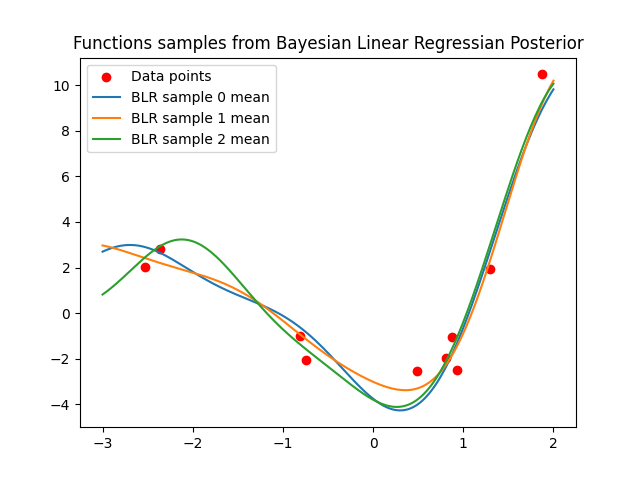

In [12]:
reg_lambda = 0.1
data_stddev = data_noise

num_rbf = 15
num_functions = 3

rbf, _ = create_rbf_feature_fun(num_rbf)
Phi = rbf(x_data)

blr_sampled_functions = posterior_sample_functions(rbf, Phi, y_data, reg_lambda, data_stddev, num_functions)


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax.plot(x_plot, y_plot, color="green", label="Ground Truth")
ax.scatter(x_data, y_data, color="red", label="Data points")
for i, fun in enumerate(blr_sampled_functions):
  ax.plot(x_plot, fun(x_plot), label=f"BLR sample {i} mean")
ax.legend(loc="upper left")
ax.set_title("Functions samples from Bayesian Linear Regressian Posterior")
None

Instead of sampling many functions and evaluating their linear Gaussian model (Monte Carlo estimate of the (posterior) predictive marginalization integral), we can use the closed form solution
$$\mu(\bm{x}^*) = \bm{\phi}(x^*)^\top (\bm{\Phi}^\top \bm{\Phi} + \sigma_{\bm{y}}\lambda \bm{I})^{-1} \bm{\Phi}^\top \bm{y}$$
and covariance
$$\sigma^2(\bm{x}^*) = \sigma_{\bm{y}} \Bigl(1 + \bm{\phi}(x^*)^\top (\bm{\Phi}^\top \bm{\Phi} + \sigma_{\bm{y}} \lambda \bm{I})^{-1} \bm{\phi}(x^*) \Bigr).$$

In [13]:
def posterior_predictive(rbf, Phi, y_data, reg_lambda, data_stddev):
    # Phi.shape [N, d]
    # mu = phi^T A^{-1} b = phi^T mean_w -> A mean_w = b
    A = Phi.mT @ Phi + data_stddev * reg_lambda * np.eye(N=Phi.shape[1], dtype=Phi.dtype)
    b = Phi.mT @ y_data
    mean_w = np.linalg.solve(A, b)  # solve d x d system

    def f(x_plot):
        assert x_plot.ndim == 1
        rbf_values = rbf(x_plot) # shape [plot, d]
        # variance = sigma_y (1 + phi^T A^{-1} phi) = sigma_y (1 + phi^T z) -> A phi = z
        # numpy want specific shape for batched solve
        z = np.linalg.solve(A, rbf_values[..., None])[..., 0] # shape [plot, d]
        # rbf shape [plot, d], mean_w shape [d], z shape [plot, d]
        mean = (rbf_values * mean_w[None, :]).sum(axis=-1)
        stddev = data_stddev * (1 + (rbf_values * z).sum(axis=-1))
        return mean, stddev

    return f


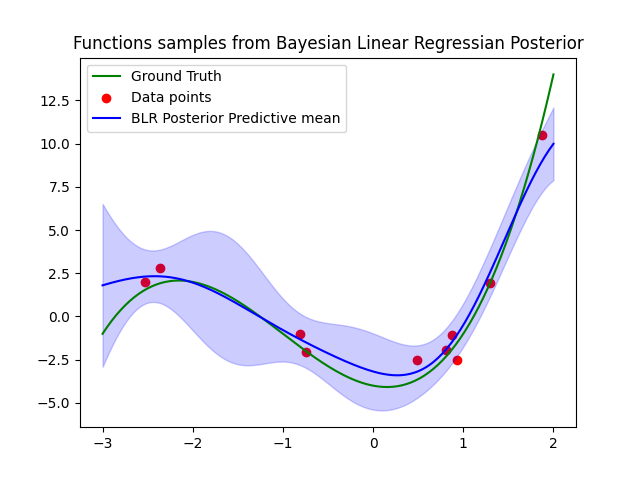

In [14]:
reg_lambda = 0.1
data_stddev = data_noise

num_rbf = 15
num_functions = 3

rbf, _ = create_rbf_feature_fun(num_rbf)
Phi = rbf(x_data)

f_predictive = posterior_predictive(rbf, Phi, y_data, reg_lambda, data_stddev)
mean, stddev = f_predictive(x_plot)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_plot, y_plot, color="green", label="Ground Truth")
ax.scatter(x_data, y_data, color="red", label="Data points")
ax.plot(x_plot, mean, color="blue", label=f"BLR Posterior Predictive mean")
ax.fill_between(x_plot, mean - stddev, mean + stddev, color="blue", alpha=0.2)
ax.legend(loc="upper left")
ax.set_title("Functions samples from Bayesian Linear Regressian Posterior")
None
